In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pymc as pm
import arviz as az
import seaborn as sns

### CONTROL CELL ###

In [2]:
# --- CONTROL BLOCK ---

# Create X and y matrices

dep = "PPCE"
ind = ["PPDI", "UMSCENT"]

# Define dates
start_training_date = pd.to_datetime('2000-01-01')
end_training_date = pd.to_datetime('2019-12-31')
start_test_date = pd.to_datetime('2020-01-01')
end_test_date = pd.to_datetime('2024-12-31')
start_fcst_date = pd.to_datetime('2025-01-01')
end_fcst_date = pd.to_datetime('2029-12-31')

# Define future X values to forecast
X_future_dict = {
    '2025-01-01': {'PPDI': 64244, 'UMSCENT': 75},
    '2026-01-01': {'PPDI': 66828, 'UMSCENT': 80},
    '2027-01-01': {'PPDI': 69499, 'UMSCENT': 85},
    '2028-01-01': {'PPDI': 72258, 'UMSCENT': 90},
    '2029-01-01': {'PPDI': 75103, 'UMSCENT': 95}
}

# Now safe to create forecast date range
index = pd.date_range(start=start_fcst_date, periods=5, freq='YS')

# Import data
df = pd.read_csv('PCE and DI Dataset.csv')

# Convert 'year' column to datetime and set as index
df['year'] = pd.to_datetime(df['year'], format='%Y')
df = df.set_index('year')

# 1. Initial Training set (2000–2019)
X_train = df.loc[(df.index >= start_training_date) & (df.index <= end_training_date), ind].values
y_train = df.loc[(df.index >= start_training_date) & (df.index <= end_training_date), dep]

# 2. Holdout Testing set (2020–2024)
X_test = df.loc[(df.index > end_training_date) & (df.index <= end_test_date), ind].values
y_test = df.loc[(df.index > end_training_date) & (df.index <= end_test_date), dep]

# 3. Final Training set for Forecasting (2000–2024)
X_train_fcst = df.loc[(df.index >= start_training_date) & (df.index <= end_test_date), ind].values
y_train_fcst = df.loc[(df.index >= start_training_date) & (df.index <= end_test_date), dep]

# Confirm split sizes
print(f"Initial Training rows: {len(y_train)}")
print(f"Testing rows: {len(y_test)}")
print(f"Forecasting Training rows: {len(y_train_fcst)}")

# Optional quick check
print(f"Training rows: {len(y_train)}")
print(f"Testing rows: {len(y_test)}")


Initial Training rows: 20
Testing rows: 5
Forecasting Training rows: 25
Training rows: 20
Testing rows: 5


### REGRESSION MODEL, VISUALS, and PERFORMANCE METRIC FUNCTIONS ###

In [3]:
#The Regression Function and the predict function

# find the best fit and then calculate the Betas
def fit_linear_regression(X, y):
    # 1. Make sure X is a NumPy array
    X = np.array(X)
    y = np.array(y)

    # 2. Add intercept (column of ones) if not already there. This allows the const B to be calculated.
    ones = np.ones((X.shape[0], 1))
    X_augmented = np.hstack((ones, X))

    # 3. Apply normal equation to calculate the Betas
    X_transpose = X_augmented.T
    XtX = X_transpose @ X_augmented
    XtX_inv = np.linalg.inv(XtX)
    Xty = X_transpose @ y
    beta = XtX_inv @ Xty

    return beta

# With Betas calculated, predict within sample by multiplying Betas by X's by creating the matrix and then multiplying it by the beta vector
def predict_linear_regression(X, beta):
    # 1. Make sure X is a NumPy array
    X = np.array(X)

    # 2. Add the column of 1's so we can calc the const
    ones = np.ones((X.shape[0], 1))
    X_augmented = np.hstack((ones, X))

    # 3. Predict
    y_fitted = X_augmented @ beta

    return y_fitted

# The visuals
def plot_true_vs_predicted(y, y_fitted):
    # Make sure y and y_fitted are NumPy arrays
    y = np.array(y)
    y_fitted = np.array(y_fitted)

    # Fit a simple linear regression y_fitted ~ y
    model = LinearRegression()
    model.fit(y.reshape(-1, 1), y_fitted)
    r2 = model.score(y.reshape(-1, 1), y_fitted)

    # Predict fitted line
    y_fit_line = model.predict(y.reshape(-1, 1))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y, y_fitted, color='blue', label='Predicted vs True')
    plt.plot(y, y_fit_line, color='green', linewidth=2, label=f'Fit Line (R² = {r2:.3f})')
    plt.xlabel('True Values (y)')
    plt.ylabel('Predicted Values (ŷ)')
    plt.title('True vs Predicted Values with Fit Line and R²')
    plt.legend()
    plt.grid(True)
    plt.show()


# Performance Metrics
def evaluate_model(y, y_fitted):
    # Mean Squared Error (MSE)
    mse = np.mean((y - y_fitted)**2)
    
    # Mean Absolute Error (MAE)
    mae = np.mean(np.abs(y - y_fitted))
    
    # R-squared (coefficient of determination)
    ss_total = np.sum((y - np.mean(y))**2)
    ss_residual = np.sum((y - y_fitted)**2)
    r2 = 1 - (ss_residual / ss_total)
    
    # Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y - y_fitted) / y)) * 100

    print(f"Model Evaluation:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"R-squared (R² Score): {r2:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    
    return mse, mae, r2, mape

def add_fitted_and_residuals(df, y_true, y_fitted):
    """
    Adds fitted values and residuals to a DataFrame,
    only for the historical period matching y_true.
    """
    df = df.copy()
    
    # Build fitted series aligned to historical dates
    y_fitted_series = pd.Series(y_fitted, index=y_true.index)
    
    df['y_fitted'] = y_fitted_series
    df['residuals'] = y_true - y_fitted_series
    
    return df

def plot_input_variables(df, ind, start_training_date, end_test_date):
    """
    Plots time series for each input (independent) variable over the training period.

    Args:
        df (pd.DataFrame): The full dataset (with datetime index)
        ind (list): List of independent variable names
        start_training_date (datetime): Training start date
        end_test_date (datetime): Training end date
    """
    # Mask for training period
    mask = (df.index >= start_training_date) & (df.index <= end_test_date)
    
    # Subset training data
    df_train = df.loc[mask]

    # Plot
    n_vars = len(ind)
    n_cols = 2
    n_rows = (n_vars + 1) // n_cols  # Enough rows for all vars

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, 4 * n_rows), sharex=True)
    axes = axes.flatten()

    for i, var in enumerate(ind):
        ax = axes[i]
        ax.plot(df_train.index, df_train[var], marker='o')
        ax.set_title(f"{var} Over Time")
        ax.set_ylabel(var)
        ax.grid(True)

   # Hide any unused subplots if odd number of vars
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Input Variable Trends (2000–2024)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_actual_vs_fitted_vs_forecast(df_combined, dep):
    """
    Plots Actual, Fitted, and Forecasted values from df_combined.
    """
    plt.figure(figsize=(14, 6))

    # Plot combined fitted + forecasted values
    plt.plot(df_combined.index, df_combined['y_comb'], label='Forecast', linestyle='-', linewidth=2)
    
    # Plot actuals
    plt.plot(df_combined.index, df_combined[dep], label='Actuals', marker='o')

    # Plot fitted values
    plt.plot(df_combined.index, df_combined['y_fitted'], label='Fitted', linestyle='--')

    
    # Add vertical line at last fitted date
    last_fitted_date = df_combined['y_fitted'].dropna().index.max()
    plt.axvline(x=last_fitted_date, color='red', linestyle='--', label='Forecast Start')

    # Titles and Labels
    plt.title('Actuals, Fitted, and Forecast')
    plt.xlabel('Year')
    plt.ylabel(dep)
    plt.grid(True)
    plt.legend()
    plt.show()

def get_evaluation_metrics(y_true, y_pred):
    """
    Calculates evaluation metrics (MSE, MAE, R², MAPE) for a model.

    Returns:
        dict of metric name: value
    """
    mse = np.mean((y_true - y_pred) ** 2)
    mae = np.mean(np.abs(y_true - y_pred))
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    return {
        'MSE': mse,
        'MAE': mae,
        'R²': r2,
        'MAPE (%)': mape
    }



### TRAINING #1 FUNCTIONS ###

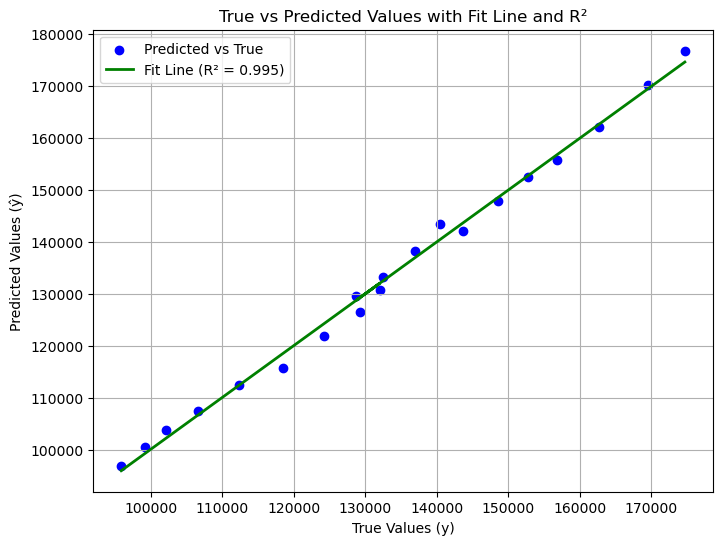

Training Period Performance:
Model Evaluation:
Mean Squared Error (MSE): 2447316.6355
Mean Absolute Error (MAE): 1338.2567
R-squared (R² Score): 0.9952
Mean Absolute Percentage Error (MAPE): 1.04%


In [4]:
# Fit model
beta_train = fit_linear_regression(X_train, y_train)

# Predict fitted
y_fitted_train = predict_linear_regression(X_train, beta_train)

# Plot fitted vs actuals
plot_true_vs_predicted(y_train, y_fitted_train)

# Print metrics
print("Training Period Performance:")
evaluate_model(y_train, y_fitted_train)

# (Optional) Collect metrics into a dict for summary table
train_metrics = get_evaluation_metrics(y_train, y_fitted_train)


### TEST FUNCTIONS ###

In [5]:
# Predict on test
y_forecast_test = predict_linear_regression(X_test, beta_train)

# (Optional) Collect metrics into dict for summary table
test_metrics = get_evaluation_metrics(y_test, y_forecast_test)

# Print metrics
print("Test Period Performance:")
evaluate_model(y_test, y_forecast_test)

Test Period Performance:
Model Evaluation:
Mean Squared Error (MSE): 99923819.6355
Mean Absolute Error (MAE): 8896.4818
R-squared (R² Score): 0.7921
Mean Absolute Percentage Error (MAPE): 4.59%


(99923819.63548209, 8896.481771759649, 0.7920628364306206, 4.594536053696372)

### RETRAIN ON ALL DATA ###

In [6]:
# Retrain on all data so we get the most uptodate betas
beta_fcst = fit_linear_regression(X_train_fcst, y_train_fcst)

# Predict fitted on 2000–2024
y_fitted_fcst = predict_linear_regression(X_train_fcst, beta_fcst)

# Calculate residuals based on the full dataset
df = add_fitted_and_residuals(df, y_train_fcst, y_fitted_fcst)

### FORWARD FORECAST FUNCTIONS ###

In [7]:
# Predict forward
future_predictions = []
for year_str, x_values in X_future_dict.items():
    year_ts = pd.to_datetime(year_str)

    # Build input array based on variable order
    x_input_list = [x_values[var_name] for var_name in ind]
    x_input = np.array([x_input_list])  # Shape (1, len(ind))

    # Predict using the FINAL trained model
    y_fcst = predict_linear_regression(x_input, beta_fcst)[0]
    
    future_predictions.append({'year': year_ts, 'y_comb': y_fcst})

# Create future DataFrame
df_future = pd.DataFrame(future_predictions).set_index('year')

# Combine historical and future
df_combined = pd.concat([df, df_future])

# Fill fitted values
df_combined.loc[(df_combined.index >= start_training_date) & (df_combined.index <= end_test_date), 'y_fitted'] = y_fitted_fcst

# Create y_comb for historical period (overwrite missing values)
df_combined['y_comb'] = df_combined['y_comb'].fillna(df_combined[dep])

# Calculate YOY % Change
df_combined['yoy_percent_change'] = df_combined['y_comb'].pct_change() * 100


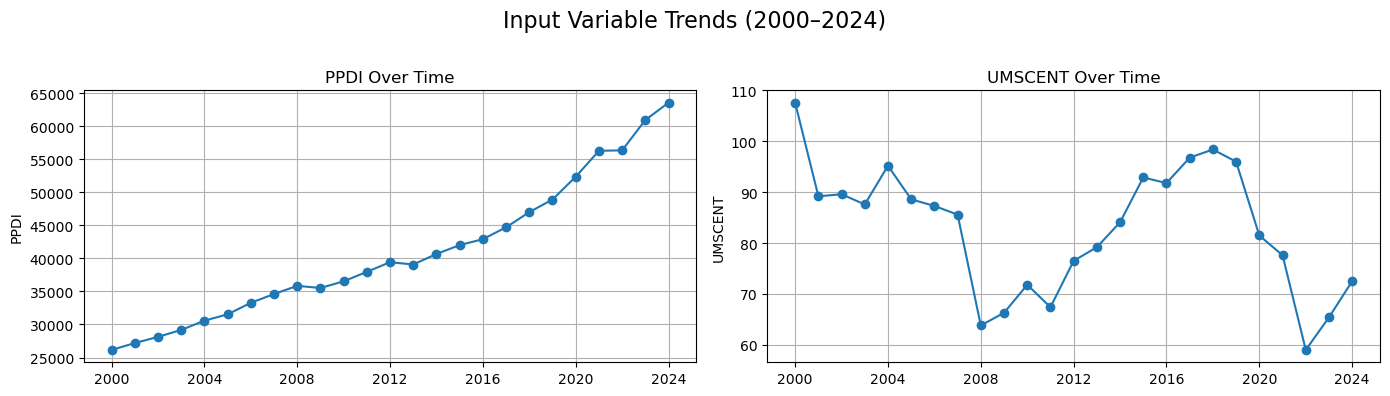

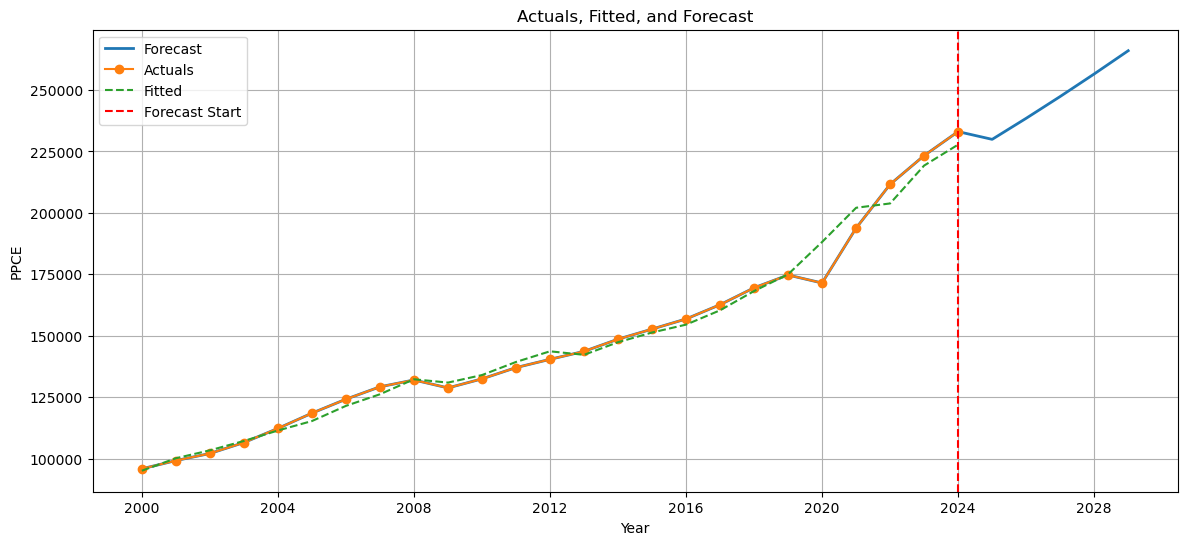

In [8]:
# Plot inputs
plot_input_variables(df, ind, start_training_date, end_test_date)

# Plot final forecast
plot_actual_vs_fitted_vs_forecast(df_combined, dep)

### BAYES MODEL FUNCTIONS ###

In [9]:
# --- BAYES ENGINE BLOCK ---

def fit_bayesian_regression(X, y, num_samples=4000):
    """
    Fits a Bayesian linear regression model using PyMC.

    Args:
        X (np.array): Feature matrix
        y (np.array): Target vector
        num_samples (int): Number of posterior samples to draw

    Returns:
        trace: PyMC InferenceData object with posterior samples
    """
    with pm.Model() as model:
        # Priors
        intercept = pm.Normal("Intercept", mu=0, sigma=10)
        coefs = pm.Normal("Coefs", mu=0, sigma=10, shape=X.shape[1])
        sigma = pm.HalfNormal("Sigma", sigma=10)

        # Linear model
        mu = intercept + pm.math.dot(X, coefs)

        # Likelihood
        y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

        # Sampling
        trace = pm.sample(num_samples, return_inferencedata=True, chains=2, target_accept=0.9)

    return trace

def predict_bayesian_fitted(X, trace):
    """
    Predicts fitted (in-sample) values from a Bayesian linear regression model.

    Args:
        X (np.array): Feature matrix
        trace: PyMC InferenceData object

    Returns:
        y_fitted_mean (np.array): Posterior mean fitted values
        fitted_samples (np.array): All fitted sample draws
    """
    intercept_samples = trace.posterior['Intercept'].values.flatten()
    coef_samples = trace.posterior['Coefs'].stack(samples=("chain", "draw")).values

    n_samples = coef_samples.shape[1]

    fitted_samples = []
    for i in range(n_samples):
        beta_0 = intercept_samples[i]
        betas = coef_samples[:, i]
        y_pred = beta_0 + np.dot(X, betas)
        fitted_samples.append(y_pred)

    fitted_samples = np.array(fitted_samples)  # Shape (n_samples, n_observations)
    y_fitted_mean = fitted_samples.mean(axis=0)

    return y_fitted_mean, fitted_samples

def predict_bayesian_forecast(X_future, trace):
    """
    Predicts future (out-of-sample) values using posterior samples.

    Args:
        X_future (np.array): Future feature matrix
        trace: PyMC InferenceData object

    Returns:
        future_samples (np.array): All future sample draws
    """
    intercept_samples = trace.posterior['Intercept'].values.flatten()
    coef_samples = trace.posterior['Coefs'].stack(samples=("chain", "draw")).values
    sigma_samples = trace.posterior['Sigma'].values.flatten()

    n_samples = coef_samples.shape[1]

    future_samples = []
    for i in range(n_samples):
        beta_0 = intercept_samples[i]
        betas = coef_samples[:, i]
        sigma = sigma_samples[i]

        # Predict mean
        y_mean = beta_0 + np.dot(X_future, betas)

        # Add uncertainty (draw from Normal)
        y_simulated = np.random.normal(loc=y_mean, scale=sigma)
        future_samples.append(y_simulated)

    future_samples = np.array(future_samples)  # Shape (n_samples, n_forecast_periods)
    return future_samples

def summarize_forecast_distribution(future_samples):
    """
    Summarizes forecast distribution (mean, 5th percentile, 95th percentile).

    Args:
        future_samples (np.array): Forecasted draws

    Returns:
        summary (dict): Dict with mean, p5, p95 arrays
    """
    mean_forecast = future_samples.mean(axis=0)
    lower_bound = np.percentile(future_samples, 5, axis=0)
    upper_bound = np.percentile(future_samples, 95, axis=0)

    summary = {
        'mean': mean_forecast,
        'p5': lower_bound,
        'p95': upper_bound
    }
    return summary

def plot_training_fit(df_combined, dep, start_training_date, end_test_date):
    """
    Plots Actuals, OLS Fitted, and Bayes Fitted values over the Training + Test period (2000–2024).
    """
    plt.figure(figsize=(12, 6))

    mask_training = (df_combined.index >= start_training_date) & (df_combined.index <= end_test_date)

    # Plot Actuals
    plt.plot(df_combined.index[mask_training], df_combined[dep][mask_training], label='Actuals', marker='o', color='black')

    # Plot OLS Fitted
    plt.plot(df_combined.index[mask_training], df_combined['y_fitted'][mask_training], label='OLS Fitted', color='blue')

    # Plot Bayes Fitted
    plt.plot(df_combined.index[mask_training], df_combined['y_fitted_bayes'][mask_training], label='Bayes Fitted', linestyle='--', color='green')

    plt.title('Model Fitted Values (Training Period)')
    plt.xlabel('Year')
    plt.ylabel(dep)
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_forecasts(df_combined, dep, start_fcst_date):
    """
    Plots Actuals, OLS Forecast, Bayes Forecast Mean, and Bayes Forecast Interval (2025–2029).
    """
    plt.figure(figsize=(12, 6))

    # 1. OLS Forecast (plot first so it's under the actuals)
    plt.plot(df_combined.index, df_combined['y_comb'], label='OLS Forecast', color='blue', linewidth=2)

    # 2. Bayes Forecast Mean
    plt.plot(df_combined.index, df_combined['y_fcst_bayes'], label='Bayes Forecast Mean', linestyle='--', color='green', linewidth=2)

    # 3. Bayes Forecast Uncertainty Interval
    plt.fill_between(
        df_combined.index,
        df_combined['y_fcst_bayes_p5'],
        df_combined['y_fcst_bayes_p95'],
        color='green',
        alpha=0.2,
        label='Bayes 90% Forecast Interval'
    )

    # 4. Actuals (always on top)
    plt.plot(df_combined.index, df_combined[dep], label='Actuals', marker='o', color='black')

    # 5. Forecast Start Line
    plt.axvline(x=start_fcst_date, color='red', linestyle='--', label='Forecast Start')

    plt.title('Forecast Comparison: OLS vs Bayes')
    plt.xlabel('Year')
    plt.ylabel(dep)
    plt.grid(True)
    plt.legend()
    plt.show()


def plot_yearly_forecast_distributions(future_samples, forecast_years):
    """
    Plots the distribution for each individual forecasted year.
    
    Args:
        future_samples (np.array): (n_samples, n_forecast_years)
        forecast_years (list of str or datetime): List of years matching the columns
    """
    n_years = future_samples.shape[1]
    
    plt.figure(figsize=(12, 6))
    
    for i in range(n_years):
        sns.kdeplot(future_samples[:, i], label=str(forecast_years[i]))
    
    plt.title('Forecast Distributions by Year')
    plt.xlabel('Forecast Value')
    plt.ylabel('Density')
    plt.legend(title='Forecast Year')
    plt.grid(True)
    plt.show()

def plot_aggregate_forecast_distribution(future_samples):
    """
    Plots the distribution for the sum of all forecasted years combined.
    """
    summed_forecasts = future_samples.sum(axis=1)

    plt.figure(figsize=(12, 6))
    sns.kdeplot(summed_forecasts, color='green', fill=True)
    plt.title('Aggregate Forecast Distribution (Sum of Future Years)')
    plt.xlabel('Total Forecasted Value (Sum)')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()


### CALL THE BAYES ENGINE ###

In [10]:
# --- BAYES CONTROL BLOCK ---

# 1. Fit Bayesian Model on Full Training Data (2000–2024)
trace_bayes = fit_bayesian_regression(X_train_fcst, y_train_fcst)

# 2. Predict Fitted Values (2000–2024)
y_fitted_bayes, fitted_samples_bayes = predict_bayesian_fitted(X_train_fcst, trace_bayes)

# 3. Predict Forward Forecast Values (2025–2029)
X_future_array = np.array([
    [X_future_dict[year][var] for var in ind] 
    for year in X_future_dict
])
future_samples_bayes = predict_bayesian_forecast(X_future_array, trace_bayes)

# 4. Summarize Forecast Distributions
forecast_summary_bayes = summarize_forecast_distribution(future_samples_bayes)

# 5. Add Fitted and Forecasted Values to df_combined
df_combined.loc[(df_combined.index >= start_training_date) & (df_combined.index <= end_test_date), 'y_fitted_bayes'] = y_fitted_bayes

forecast_years = pd.to_datetime(list(X_future_dict.keys()))
df_combined.loc[forecast_years, 'y_fcst_bayes'] = forecast_summary_bayes['mean']
df_combined.loc[forecast_years, 'y_fcst_bayes_p5'] = forecast_summary_bayes['p5']
df_combined.loc[forecast_years, 'y_fcst_bayes_p95'] = forecast_summary_bayes['p95']

# 6. Preview
print(df_combined[['y_fitted_bayes', 'y_fcst_bayes', 'y_fcst_bayes_p5', 'y_fcst_bayes_p95']])


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Intercept, Coefs, Sigma]


Output()

Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 24 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


            y_fitted_bayes   y_fcst_bayes  y_fcst_bayes_p5  y_fcst_bayes_p95
year                                                                        
2000-01-01    95939.320805            NaN              NaN               NaN
2001-01-01    99227.416403            NaN              NaN               NaN
2002-01-01   102583.715984            NaN              NaN               NaN
2003-01-01   106293.797569            NaN              NaN               NaN
2004-01-01   111489.042751            NaN              NaN               NaN
2005-01-01   114759.646550            NaN              NaN               NaN
2006-01-01   120981.632031            NaN              NaN               NaN
2007-01-01   125671.175792            NaN              NaN               NaN
2008-01-01   129644.636446            NaN              NaN               NaN
2009-01-01   128517.066797            NaN              NaN               NaN
2010-01-01   132259.702684            NaN              NaN               NaN

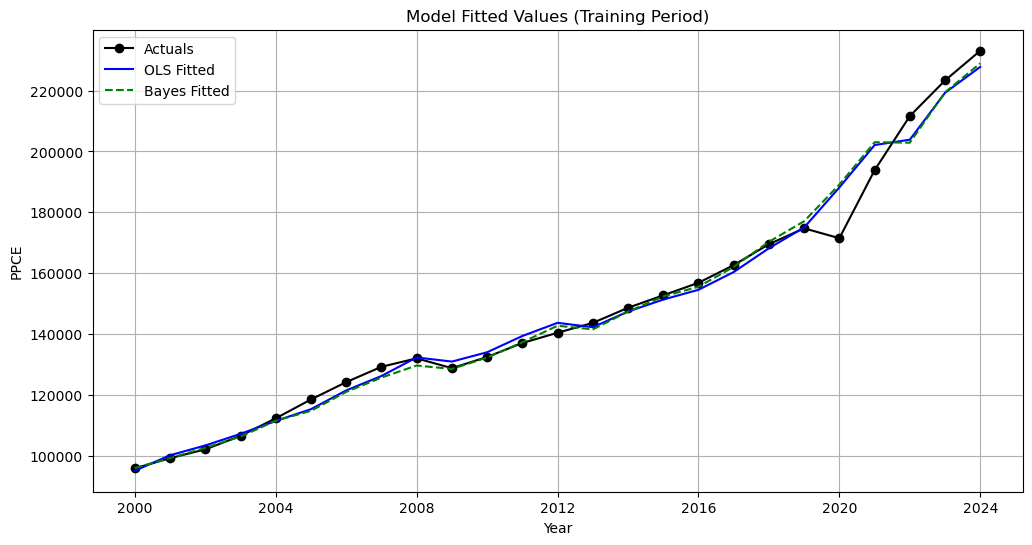

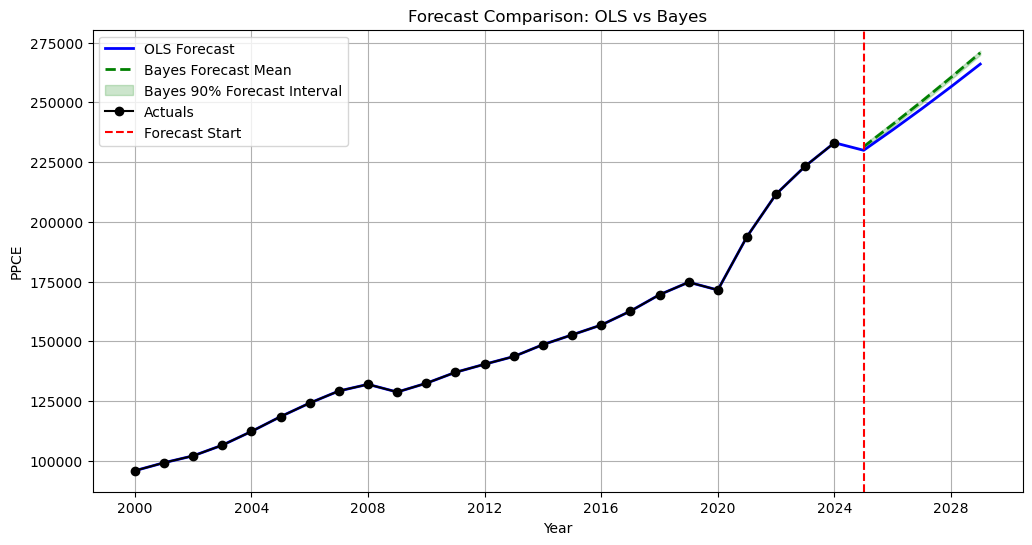

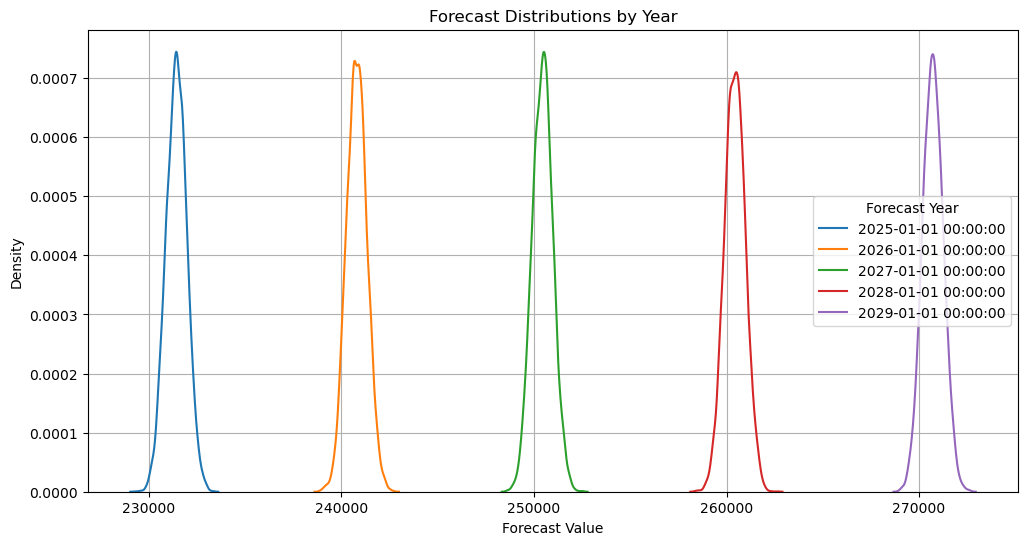

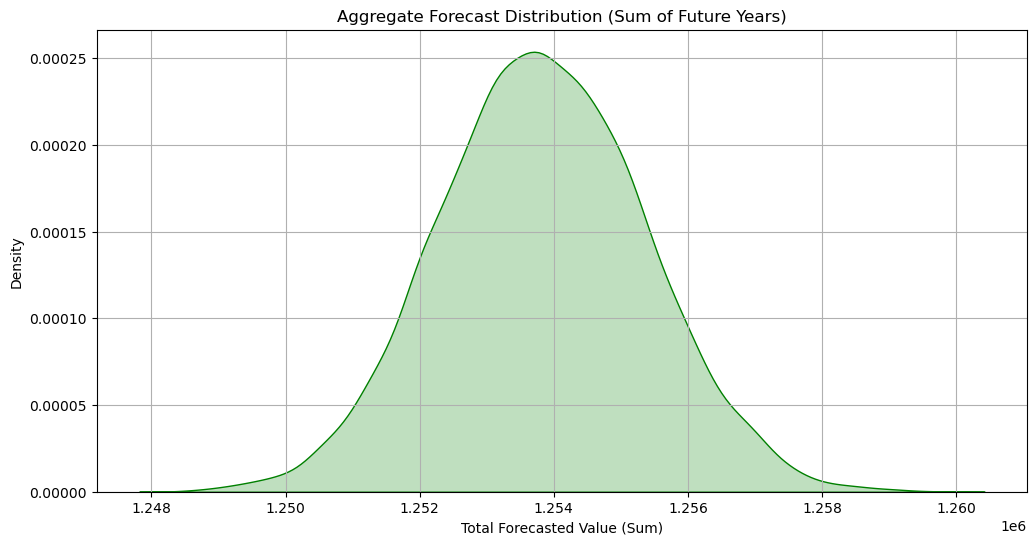

In [11]:
# Assess the fit of OLS and Bayes with actuals
plot_training_fit(df_combined, dep, start_training_date, end_test_date)

# Compare forecasts
plot_forecasts(df_combined, dep, start_fcst_date)

# After you have your future_samples_bayes (n_samples, 5 years)
forecast_years = pd.to_datetime(list(X_future_dict.keys()))

# Plot individual year distributions
plot_yearly_forecast_distributions(future_samples_bayes, forecast_years)

# Plot total aggregate distribution
plot_aggregate_forecast_distribution(future_samples_bayes)

### BOOTSTRAP RESIDUAL FUNCTIONS ###

In [12]:
def simulate_bootstrap_forecasts(X_future_array, beta, residuals, n_simulations=4000):
    """
    Simulates bootstrapped forecast paths by resampling residuals.

    Args:
        X_future_array (np.array): Future X values (n_periods x n_features)
        beta (np.array): OLS model coefficients
        residuals (np.array): Residuals from training set
        n_simulations (int): Number of simulations to run

    Returns:
        np.array: (n_simulations, n_forecast_periods) of simulated forecasts
    """
    n_periods = X_future_array.shape[0]
    
    # Create container
    simulated_forecasts = np.zeros((n_simulations, n_periods))
    
    for i in range(n_simulations):
        for t in range(n_periods):
            x_input = X_future_array[t].reshape(1, -1)  # ensure 2D input
            y_hat = predict_linear_regression(x_input, beta)[0]  # point prediction
            boot_resid = np.random.choice(residuals)  # sample a residual
            simulated_forecasts[i, t] = y_hat + boot_resid  # add sampled noise
    
    return simulated_forecasts

def summarize_bootstrap_distribution(simulated_forecasts):
    """
    Summarizes the bootstrapped forecast distributions for each period.

    Args:
        simulated_forecasts (np.array): (n_simulations, n_periods)

    Returns:
        pd.DataFrame: Summary with columns [mean, p5, p95] for each forecasted period
    """
    summary = {
        'mean': simulated_forecasts.mean(axis=0),
        'p5': np.percentile(simulated_forecasts, 5, axis=0),
        'p95': np.percentile(simulated_forecasts, 95, axis=0)
    }
    return pd.DataFrame(summary)

from statsmodels.tsa.stattools import adfuller

def check_residual_stationarity(residuals):
    """
    Runs Augmented Dickey-Fuller test on residuals to check for stationarity.

    Args:
        residuals (array-like): Residuals from model

    Prints:
        ADF test statistic and p-value
    """
    adf_result = adfuller(residuals)
    test_stat = adf_result[0]
    p_value = adf_result[1]
    
    print(f"ADF Test Statistic: {test_stat:.4f}")
    print(f"p-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("✅ Residuals are stationary. Good for bootstrapping.")
    else:
        print("⚠️ Residuals may not be stationary. Be cautious with bootstrap results.")


In [13]:
# --- RESIDUAL BOOTSTRAP CONTROL BLOCK ---

# 1. Prepare future X array
X_future_array = np.array([
    [X_future_dict[year][var] for var in ind]
    for year in X_future_dict
])

# 2. Are the residuals stationary?  If not, then the bootstrap method won't work
check_residual_stationarity(df['residuals'].dropna())

# 3. Pull historical residuals
residuals_train = df_combined.loc[(df_combined.index >= start_training_date) & (df_combined.index <= end_test_date), 'residuals'].dropna().values

# 4. Simulate
simulated_forecasts_bootstrap = simulate_bootstrap_forecasts(X_future_array, beta_fcst, residuals_train, n_simulations=4000)

# 5. Summarize
bootstrap_summary = summarize_bootstrap_distribution(simulated_forecasts_bootstrap)

# 6. Add results back to df_combined
forecast_years = pd.to_datetime(list(X_future_dict.keys()))
df_combined.loc[forecast_years, 'y_fcst_bootstrap'] = bootstrap_summary['mean'].values
df_combined.loc[forecast_years, 'y_fcst_bootstrap_p5'] = bootstrap_summary['p5'].values
df_combined.loc[forecast_years, 'y_fcst_bootstrap_p95'] = bootstrap_summary['p95'].values

# 7. Preview
print(df_combined[['y_fcst_bootstrap', 'y_fcst_bootstrap_p5', 'y_fcst_bootstrap_p95']])


ADF Test Statistic: -1.0887
p-value: 0.7196
⚠️ Residuals may not be stationary. Be cautious with bootstrap results.
            y_fcst_bootstrap  y_fcst_bootstrap_p5  y_fcst_bootstrap_p95
year                                                                   
2000-01-01               NaN                  NaN                   NaN
2001-01-01               NaN                  NaN                   NaN
2002-01-01               NaN                  NaN                   NaN
2003-01-01               NaN                  NaN                   NaN
2004-01-01               NaN                  NaN                   NaN
2005-01-01               NaN                  NaN                   NaN
2006-01-01               NaN                  NaN                   NaN
2007-01-01               NaN                  NaN                   NaN
2008-01-01               NaN                  NaN                   NaN
2009-01-01               NaN                  NaN                   NaN
2010-01-01          

### SUMMARY FUNCTIONS ###

In [14]:
def plot_all_forecasts(df_combined, dep):
    """
    Plot Actuals, OLS Forecast, Bayes Forecast, and Bootstrap Forecast with uncertainty bands.
    """
    plt.figure(figsize=(14, 7))

    # Plot actuals
    plt.plot(df_combined.index, df_combined[dep], label='Actuals', marker='o', color='black')

    # Plot OLS fitted + OLS forecast
    plt.plot(df_combined.index, df_combined['y_comb'], label='OLS (Fitted + Forecast)', linestyle='--', color='blue')

    # Plot Bayesian forecast mean
    plt.plot(df_combined.index, df_combined['y_fcst_bayes'], label='Bayes Forecast (Mean)', linestyle='-', color='orange')

    # Bayesian 90% credible interval
    plt.fill_between(
        df_combined.index,
        df_combined['y_fcst_bayes_p5'],
        df_combined['y_fcst_bayes_p95'],
        color='orange',
        alpha=0.3,
        label='Bayes 90% CI'
    )

    # Bootstrap forecast mean
    plt.plot(df_combined.index, df_combined['y_fcst_bootstrap'], label='Bootstrap Forecast (Mean)', linestyle='-', color='green')

    # Bootstrap 90% prediction interval
    plt.fill_between(
        df_combined.index,
        df_combined['y_fcst_bootstrap_p5'],
        df_combined['y_fcst_bootstrap_p95'],
        color='lightgreen',
        alpha=0.4,
        label='Bootstrap 90% PI'
    )

    # Forecast start
    forecast_start_date = df_combined['y_fitted'].dropna().index.max()
    plt.axvline(x=forecast_start_date, color='red', linestyle='--', label='Forecast Start')

    plt.title('Actuals, OLS, Bayes, and Bootstrap Forecasts')
    plt.xlabel('Year')
    plt.ylabel(dep)
    plt.grid(True)
    plt.legend()
    plt.show()


def summarize_forecast_table_with_colors(df_combined, forecast_years):
    """
    Summarizes forecast values for OLS, Bayes, and Bootstrap for each future year,
    and applies color highlighting.
    """
    summary_table = df_combined.loc[forecast_years, [
        'y_comb',
        'y_fcst_bayes', 'y_fcst_bayes_p5', 'y_fcst_bayes_p95',
        'y_fcst_bootstrap', 'y_fcst_bootstrap_p5', 'y_fcst_bootstrap_p95'
    ]].copy()
    
    summary_table.rename(columns={
        'y_comb': 'OLS Forecast',
        'y_fcst_bayes': 'Bayes Mean',
        'y_fcst_bayes_p5': 'Bayes P5',
        'y_fcst_bayes_p95': 'Bayes P95',
        'y_fcst_bootstrap': 'Bootstrap Mean',
        'y_fcst_bootstrap_p5': 'Bootstrap P5',
        'y_fcst_bootstrap_p95': 'Bootstrap P95'
    }, inplace=True)

    # Round nicely
    summary_table = summary_table.round(1)

    # Apply color styling
    styled_table = summary_table.style.background_gradient(
        cmap='Greens', axis=0, subset=['OLS Forecast', 'Bayes Mean', 'Bootstrap Mean']
    ).background_gradient(
        cmap='Reds_r', axis=0, subset=['Bayes P5', 'Bayes P95', 'Bootstrap P5', 'Bootstrap P95']
    ).format("{:,.1f}")

    return styled_table


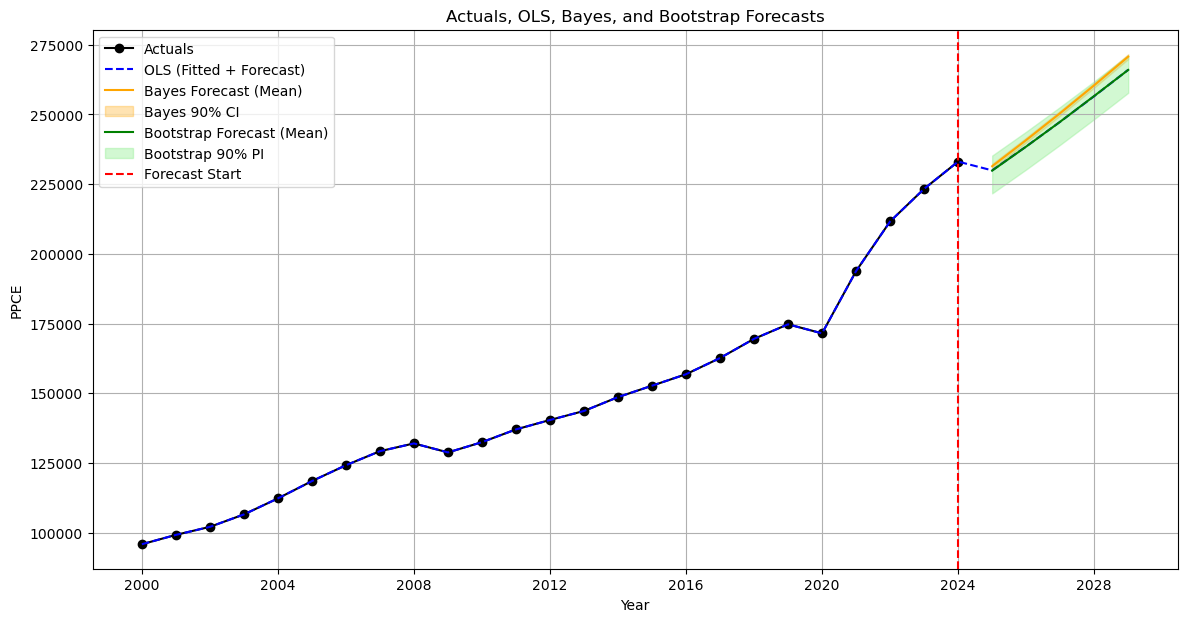

,OLS Forecast,Bayes Mean,Bayes P5,Bayes P95,Bootstrap Mean,Bootstrap P5,Bootstrap P95
2025-01-01 00:00:00,"229,935.8","231,429.9","230,544.1","232,309.7","229,852.7","221,684.9","235,241.2"
2026-01-01 00:00:00,"238,499.8","240,795.4","239,935.7","241,671.2","238,463.7","230,248.8","243,805.2"
2027-01-01 00:00:00,"247,365.8","250,444.5","249,567.2","251,327.6","247,382.5","239,114.8","252,671.2"
2028-01-01 00:00:00,"256,537.2","260,434.1","259,567.6","261,327.3","256,605.1","248,286.2","261,842.6"
2029-01-01 00:00:00,"266,007.1","270,718.5","269,859.8","271,598.6","265,972.4","257,756.2","271,312.6"


In [15]:
# 1. Chart
plot_all_forecasts(df_combined, dep)

# 2. Table
forecast_years = pd.to_datetime(list(X_future_dict.keys()))
styled_table = summarize_forecast_table_with_colors(df_combined, forecast_years)
styled_table
